---
title: Validating your data product 
authors: 
- name: Genevive Clow
---

In [14]:
#%pip install xarray==2024.05.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports
#%pip install pykrige
#%pip install xarray
# %pip install xarray==2024.05.0

%matplotlib widget

%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
#from skimage import exposure
#from skimage.io import imsave, imread
#from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
#from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess
import gzip
import s3fs

In [3]:
# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
from ipywidgets import interact, Dropdown
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
#from pykrige.ok import OrdinaryKriging
from sklearn.linear_model import LinearRegression, RANSACRegressor
from scipy.odr import Model, RealData, ODR
import scipy.odr as odr
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon, Point
import pygmt
import gc
import pytz
import pyproj
import math
from pathlib import Path
from matplotlib.patches import Polygon as Pgon
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import SSTutils as sut

import warnings
warnings.filterwarnings('ignore')

## Why do we need to validate?
Now we have our calibrated SST data product! 🥳 We're almost ready to use this data product for our scientific analysis, but there is still one more important step. As a quick reminder, our data product was derived from top-of-atmosphere radiance measurements. We then converted these radiances into actual SST values (in units of temperature) by calibrating with another satellite (MODIS). But can we trust that these derived SST values are accurately reflecting real ocean surface temperatures? Validation allows us to quantitfy the uncertainty of our product.

## Finding data to validate with
When validating satellite products, we typically want to use in situ measurements: i.e., direct measurements taken in the field. For the ocean, these measurements come from buoys, ship-based thermometers and autonomous floats. An important thing to keep in mind is that while satellites measure the skin temperature (top ~10–20 microns), in situ platforms measure bulk SST (a few cm to 1 m depth). 

Should be high quality!

Finding a good validation dataset can be tricky. Here's are some lists of commonly-used validation datasets to help get you started: 

TO DO: These links need to be checked

```{admonition} 🌊 Ocean 
:class: toggle
    
| **Dataset**        | **Access**                                                                                                                                                                                                                                                                                                   | **Variables**                     |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --------------------------------- |
| **Argo**           | [argo.ucsd.edu](https://argo.ucsd.edu/data/acknowledging-argo/)  — DOI: [10.17882/42182](https://doi.org/10.17882/42182) <br> [NOAA archive](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc%3AArgo-Monthly) — DOI: [10.25921/q97e‑d719](https://doi.org/10.25921/q97e-d719) | Sea surface temperature, salinity |
| **GHRSST iQuam**   | [GHRSST iQuam website](https://www.star.nesdis.noaa.gov/socd/sst/iquam/) <br> [GHRSST documentation (Zenodo)](https://doi.org/10.5281/zenodo.7589540)                                                                                                                                                        | Sea surface temperature           |
| **GTSPP**          | [NCEI GTSPP access](https://www.ncei.noaa.gov/products/global-temperature-salinity-profile-program)                                                                                                                                                                                                          | Temperature, salinity profiles    |
| **SPURS**          | [SPURS homepage (NASA)](https://spurs.jpl.nasa.gov/)                                                                                                                                                                                                                                                         | Sea surface salinity              |
| **SeaBASS**        | [seabass.gsfc.nasa.gov](https://seabass.gsfc.nasa.gov/)                                                                                                                                                                                                                                                      | Ocean color, chlorophyll-a        |
| **NOMAD**          | [NOMAD at NOAA STAR](https://www.star.nesdis.noaa.gov/socd/ocean/color/NOMAD/NOMAD.shtml)                                                                                                                                                                                                                    | Ocean color, chlorophyll-a        |
| **BOUSSOLE**       | [BOUSSOLE Project](https://www.obs-vlfr.fr/Boussole/html/home/home.php)                                                                                                                                                                                                                                      | Ocean color, optics, chlorophyll  |
| **GDP (Drifters)** | [Global Drifter Program](https://www.aoml.noaa.gov/phod/gdp/)                                                                                                                                                                                                                                                | Ocean surface currents            |
| **HF Radar**       | [HFRNet Portal](https://hfrnet.ucsd.edu/)                                                                                                                                                                                                                                                                    | Ocean surface currents            |
| **ADCP**           | [NOAA ADCP Program](https://www.aoml.noaa.gov/phod/goos/adcp/index.php)                                                                                                                                                                                                                                      | Water column currents             |


```

```{admonition} ⛅️ Atmosphere 
:class: toggle
    
| **Dataset**    | **Access**                                                                                                                    | **Variables**                             |
| -------------- | ----------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------- |
| **AERONET**    | [aeronet.gsfc.nasa.gov](https://aeronet.gsfc.nasa.gov/) <br> [re3data entry](https://www.re3data.org/repository/r3d100011742) | Aerosol optical depth (AOD), aerosol type |
| **IGRA**       | [IGRA at NOAA](https://www.ncei.noaa.gov/products/integrated-global-radiosonde-archive)                                       | Atmospheric temperature, pressure         |
| **GRUAN**      | [GRUAN](https://www.gruan.org/)                                                                                               | Temperature, humidity, pressure           |
| **METAR/ASOS** | [Iowa State Mesonet](https://mesonet.agron.iastate.edu/request/download.phtml)                                                | Surface temperature, pressure             |
| **GPM-GV**     | [NASA GPM Ground Validation](https://gpm.nasa.gov/resources/ground-validation)                                                | Precipitation                             |
| **GPCC**       | [GPCC at DWD](https://opendata.dwd.de/climate_environment/GPCC/)                                                              | Precipitation                             |
| **SKYNET**     | [Chiba University SKYNET](http://atmos.cr.chiba-u.ac.jp/skynet/)                                                              | Aerosols, AOD                             |
| **MPLNET**     | [MPLNET at NASA](https://mplnet.gsfc.nasa.gov/)                                                                               | Aerosols, clouds                          |
| **TCCON**      | [TCCON Data Portal](https://tccondata.org/)                                                                                   | CO₂, CH₄, other trace gases               |
| **Pandora**    | [Pandora Project](https://pandora.gsfc.nasa.gov/)                                                                             | NO₂, O₃, trace gases                      |
| **MAX-DOAS**   | [MAX-DOAS Network](https://uv-vis.aeronomie.be/maxdoas/)                                                                      | NO₂, SO₂, HCHO                            |
```

```{admonition} 🌳 Land
:class: toggle

| **Dataset**  | **Access**                                                           | **Variables**                          |
| ------------ | -------------------------------------------------------------------- | -------------------------------------- |
| **SURFRAD**  | [NOAA SURFRAD](https://www.esrl.noaa.gov/gmd/grad/surfrad/)          | Land surface temperature, radiation    |
| **BSRN**     | [BSRN](https://bsrn.awi.de/)                                         | Solar radiation, surface energy fluxes |
| **FLUXNET**  | [fluxnet.org](https://fluxnet.org/)                                  | LST, vegetation indices, fluxes        |
| **SCAN**     | [USDA SCAN](https://www.wcc.nrcs.usda.gov/scan/)                     | Soil moisture                          |
| **ISMN**     | [International Soil Moisture Network](https://ismn.earth/)           | Soil moisture                          |
| **Phenocam** | [Phenocam Network](https://phenocam.sr.unh.edu/)                     | Vegetation phenology (NDVI proxy)      |
| **NEON**     | [NEON Data Portal](https://www.neonscience.org/)                     | Vegetation indices, climate variables  |
| **BELMANIP** | [Copernicus Land Service](https://land.copernicus.eu/global/sites)   | Leaf area index (LAI)                  |
| **VALERI**   | [VALERI Project](https://w3.avignon.inrae.fr/valeri/)                | LAI, fAPAR                             |
| **DIRECT**   | [VALERI/DIRECT Info](https://www.avignon.inrae.fr/valeri/?q=node/13) | LAI                                    |
``` 

```{admonition} ❄️ Cryosphere 
:class: toggle
 
| **Dataset**          | **Access**                                                                                                       | **Variables**                        |
| -------------------- | ---------------------------------------------------------------------------------------------------------------- | ------------------------------------ |
| **SnowEx**           | [NASA SnowEx](https://snow.nasa.gov/campaigns/snowex)                                                            | Snow depth, snow cover, SWE          |
| **CALVAL (NSIDC)**   | [NSIDC Cal/Val](https://nsidc.org/data/calval)                                                                   | Snow, cryosphere                     |
| **GSNOW**            | [NOAA GSNOW](https://www.ncei.noaa.gov/products/snow-cover)                                                      | Snow cover                           |
| **NSIDC**            | [NSIDC](https://nsidc.org/)                                                                                      | Sea ice, snow cover                  |
| **IABP (Ice Buoys)** | [International Arctic Buoy Program](https://iabp.apl.uw.edu/)                                                    | Sea ice concentration, drift         |
| **IceBridge**        | [NASA IceBridge](https://nsidc.org/data/icebridge)                                                               | Ice sheet elevation, thickness       |
| **ATM**              | [Airborne Topographic Mapper (ATM)](https://nsidc.org/data/ILATM2)                                               | Ice elevation profiles               |
| **NOHRSC**           | [NOAA NOHRSC](https://www.nohrsc.noaa.gov/)                                                                      | Snow depth and snow water equivalent |
| **CCSN (Canada)**    | [Canadian Cryospheric Snow Network](https://open.canada.ca/data/en/dataset/5ff9d50e-591f-4e06-9b8f-0a707e8a1a74) | Snow depth, SWE                      |
```

### Example: GHRSST iQUAM data
For our new SST product, we'll use the GHRSST iQUAM dataset for validation. GHRSST is the Group for High Resolution Sea Surface Temperature – an international collaboration supporting high-quality SST products for research and operational use – and iQuam is a system developed by NOAA to collect, quality-control (QC), and distribute in situ SST observations in near real-time and delayed mode. This dataset aggregates SST measurements from a variety of in situ platforms, such as drifting buoys, moored buoys, shipboard sensors, and Argo floats. 

https://www.star.nesdis.noaa.gov/socd/sst/iquam/?tab=0&dateinput_year=2023&dateinput_month=02&dayofmoninput_day=26&dateinput_hour=00&dayofmon=monthly&qcrefsst=_qcrey&qcrefsst=_qccmc&outlier=qced#qmap

## Finding data matchups

Here are some important considerations we need to make when finding matchups between the satellite product and in situ datasets:

🔹 **1. Spatial Collocation**
- Footprint Differences: Satellite pixels often represent an area (e.g., 1 km² or more), while in situ data may be point measurements.
    - Solution: Use in situ data averaged over the satellite footprint or compare satellite data averaged over multiple pixels surrounding the in situ point.

- Geolocation Accuracy: Both satellite and in situ positions should be accurately known, especially in dynamic environments (e.g., drifting buoys).

- Environmental Variability: Spatial gradients (e.g., near coastlines or fronts) can lead to mismatches even with close locations.

🔹 **2. Temporal Matching**
- Temporal Resolution: Satellites provide snapshots (sometimes daily, sometimes instantaneous), while in situ data may be continuous or periodic.
    - Solution: Match satellite observation time as closely as possible to in situ sampling time (e.g., within ±1 hour).

- Diurnal Effects: Some variables (e.g., SST, radiative fluxes) vary significantly throughout the day.
    - Solution: Use diurnal correction or only match at known overpass times (e.g., MODIS ~1:30 pm local time).

🔹 **3. Variable Definitions and Depths**
- Depth Differences: For example, satellite SST represents skin temperature (top ~10–20 μm), whereas in situ sensors often measure at ~1 m.
    - Solution: Apply a skin-to-bulk correction or compare to “foundation temperature” from models.
- Variable Representation: Ensure the in situ measurement is of the same quantity the satellite estimates (e.g., top-of-canopy reflectance vs. leaf-level LAI).

🔹 **4. Quality Control**
- Flagging: Use only high-quality satellite and in situ data (e.g., use quality flags to exclude cloud-contaminated pixels or questionable sensor readings).
- Consistency in Units and Calibration: Verify that data are in the same units and reference systems (e.g., radiance vs. reflectance, SI units).
- Error Estimates: Consider measurement uncertainty and noise in both datasets.

🔹 **5. Statistical Considerations**
- Matchup Volume: A large number of matchup pairs increases robustness.
- Bias and RMSE Analysis: Use metrics like bias, RMSE, and correlation to assess agreement.
- Outlier Handling: Identify and analyze outliers to understand limitations or failure modes.

🔹 **6. Sensor Calibration**
- Ensure both satellite and in situ instruments are properly calibrated and traceable to standards.

🔹 **7. Geophysical Context**
- Geographical Diversity: Validation should include diverse regions (e.g., open ocean, coastal, tropical, polar) to capture algorithm performance globally. In our example, we are only validating our product near Antarctica, so we should only use this product in that region. 

In order to maximize the number of data matchups while still making a fair comparison, we need to determine an appropriate window in space and time. In our example, we set our spatial window to 1 km and our temporal window to half of a day:
```
dist = 1.0
time_add = 0.5
```

In [4]:
# Landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# Add Jetstream2 access
jetstream_url = 'https://js2.jetstream-cloud.org:8001/'
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=jetstream_url))
iQfiles=s3.ls('pythia/landsat8/iQuam') 
print(iQfiles)

# Paths
basepath = Path('/home/jovyan/landsatproduct-cookbook')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'
SSTpath = lsatpath / 'SST/Validation/iQuamIntercomp/'
#iQpath = lsatpath / 'iQuam'

WV = 'Water_Vapor'

# For geopandas and tile plots
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}_iQuam.geojson'

# Buffer around iquam point used to create a bounding box for Landsat sample
dist = 1.0 # km

# Temporal search range (days) before/after iquam measurement for finding Landsat image
time_add = 0.5

lthresh = -1.9

interp = 1

['pythia/landsat8/iQuam/202009-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv04.0.nc', 'pythia/landsat8/iQuam/202010-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv05.0.nc', 'pythia/landsat8/iQuam/202011-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv07.0.nc', 'pythia/landsat8/iQuam/202012-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv11.0.nc', 'pythia/landsat8/iQuam/202101-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc', 'pythia/landsat8/iQuam/202102-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc', 'pythia/landsat8/iQuam/202103-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv06.0.nc', 'pythia/landsat8/iQuam/202109-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc', 'pythia/landsat8/iQuam/202110-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv05.0.nc', 'pythia/landsat8/iQuam/202111-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc', 'pythia/landsat8/iQuam/202112-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv03.0.nc', 'pythia/landsat8/iQuam/202201-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc', 'pythia/landsat8/iQuam/202202-STAR-L2i_

In [5]:
# Year and months desired (multiple years)
start_yr = 2013
end_yr = 2023

# Note these will get months from the later part of the year to early next
start_mo = '09'
end_mo = '03'

# Headers for the saved outputs
headers = ['DateTime','L8_filename','L8_SST','L8_std','center','N','S','E','W','NE','SE','NW','SW','L8_SST_max','L8_SST_min','Argo_id','Argo_SST','A_lat','A_lon']

# Desired projection transformation
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the Landsat file

Now we're ready to find our matchups!

We're repeating the retrieval step for the locations where we have data matchups.

In [9]:
%%time

# Multiple years

# Set up projections
transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Get iQuam file paths in directory between desired dates and find and produce matching Landsat SSTs 
for year in range(start_yr, end_yr):  
    yrmo = []
    start_yrmo = f"{year}{start_mo}"  # Start from September of the current year
    end_yrmo = f"{year+1}{end_mo}"  # End in March of the next year

    m0 = start_yrmo
    
    # Make a list of months between start and end
    while int(m0) <= int(end_yrmo):
        calc_dt = datetime.strptime(f'{m0[:4]}-{m0[4:]}', '%Y-%m')
        yrmo.append(calc_dt.strftime("%Y%m"))
        m0 = (calc_dt + relativedelta(months=1)).strftime("%Y%m")
    
    # Get file names and select only those matching dates from yrmo  
    #iQfiles = os.listdir(iQpath)
    s3path = 's3://pythia/landsat8/iQuam/*.nc'
    iQfiles = s3.glob(s3path)
    #s3.invalidate_cache()

    #iQfiles = [x for x in iQfiles if x[:6] in yrmo]
    iQfiles = [x for x in iQfiles if x[22:22+6] in yrmo]
    iQfiles.sort(reverse=True)
    print (f'{year}: {len(iQfiles)}')
    
    #os.chdir(iQpath)

    # For each iquam file, pair West Antarctic Argo buoy data with Landsat data and create calibrated SSTs
    valid = []
    
    for iquam_file in iQfiles:
        print(iquam_file)
        print('s3://'+iquam_file)
        # Open Argos data from iQuam file
        
        df = xr.open_dataset('s3://'+iquam_file)
        iquam = df.to_dataframe()
        
        # Subset to Antarctica
        ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
        # ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
        
        # To remove a landsat day that is coming up with a 403 error
        if ant['year'].iloc[0] == 2020 and ant['month'].iloc[0] == 12:
            ant = ant[ant.day != 9.0] # for 202012 because otherwise will fail
        
        print('')
        print(f'{iquam_file[:6]}: {ant.shape[0]} measurements')
    
        for idx in tqdm(range(ant.shape[0]), desc="Processing"):
    
            # Create search area
            ilat = ant['lat'].iloc[idx]
            ilon = ant['lon'].iloc[idx]
    
            lat_add = sut.km_to_decimal_degrees(dist, ilat, direction='latitude')
            lon_add = sut.km_to_decimal_degrees(dist, ilat, direction='longitude')
            bboxV = (ilon-lon_add,ilat-lat_add,ilon+lon_add,ilat+lat_add)
    
            # Create Landsat temporal search range in correct format
            ihr = int(ant.hour.iloc[idx])
            iyr = int(ant.year.iloc[idx])
            imo = int(ant.month.iloc[idx])
    
            calc_dt = datetime.strptime(f'{iyr}-{imo}-{int(ant.day.iloc[idx])} {ihr}', '%Y-%m-%d %H')
            start_dt = (calc_dt + timedelta(days=-time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
            end_dt = (calc_dt + timedelta(days=time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
    
            timeRangeV = f'{start_dt}/{end_dt}'
    
            # Search for desired Landsat scenes
            items = sut.search_stac(url,collection,gjson_outfile=gjson_outfile,bbox=bboxV,timeRange=timeRangeV)
    
            # Load the geojson file and open stac catalog
            catalog = intake.open_stac_item_collection(items)
            gf = gpd.read_file(gjson_outfile)
    
            # Exclude Landsat 9
            catalog_list = [x for x in items if x.id[3]=='8']
            num_scene = len(catalog_list)
            # print(f'{num_scene} Landsat 8 items')
    
            # If any matching landsat scenes are found create calibrated SSTs for them
            if num_scene>0:
    
                # Reproject to determine bounding box in espg 3031
                sbox,checkbox = sut.lsat_reproj(source_crs,target_crs,(bboxV[0],bboxV[1],bboxV[2],bboxV[3]))
    
                # Create polygon for later cropping
                polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])
                
                # Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
                minx, miny, maxx, maxy = polygon.bounds
                polarx = [minx, maxx]
                polary = [miny, maxy]
    
                # Create calibrated SSTs for each matching landsat scene
                for sceneid in catalog_list:
                    print(sceneid.id)
    
                    scene = catalog[sceneid.id]
                    timestr = scene.metadata['datetime'].strftime('%H%M%S')
    
                    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
                    if os.path.isfile(outFile):
                        print (f'{sceneid.id} - atm corr exists')
                        ls_scene = xr.open_dataset(outFile,chunks=dict(x=512, y=512),engine='rasterio')
                        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
                        # Subset all scenes and check for right dimensions because y order changes sometimes
                        ls_sub = sut.subset_img(ls_scene['band_data'].sel(band=1),polarx,polary) # subset so easier to work with
    
                    else:
                        # try:
                        # Open all desired bands for one scene
                        ls_scene = sut.landsat_to_xarray(sceneid,catalog)
                        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
        
                        # Create classification mask
                        ls_scene = sut.create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)

                        # Check for any open ocean pixels - go to next image if none - ??? s
                        mask = np.ones(ls_scene.shape[1:])
                        mask[ls_scene.mask!=3] = np.nan
                        ls_thermal = ls_scene.sel(band='lwir11').compute()

                        # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
                        ls_box = sut.subset_img(ls_thermal*mask,polarx,polary)

                        if ((ls_box).notnull()).sum().values==0:
                            print (f'{sceneid.id} has no SSTs')
                            try:
                                del ls_scene, scene, mask, ls_thermal, ls_box
                            except:
                                pass
                            gc.collect()
                            continue

                        # Use band ratios for RF cloud pixel classification
                        ####

                        # Atmospheric correction using MODIS
                        # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
                        mod07,modfilenm = sut.open_MODIS(ls_scene,scene,modout_path)
                        print("1")

                        # Create water vapor files aligned and subsampled to Landsat
                        spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
                        WV_xr = sut.get_wv(ls_scene,mod07,spacing,WV,scene,interp=interp)
                        print("2")
                        # Create SST by masking and using water vapor to apply atmospheric correction
                        SST = sut.apply_retrieval(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer)

                        # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
                        # data variables in COG (click on white paper info button in xarray readout)
                        SST.attrs['MODIS_WV'] = modfilenm

                        # Save to a cloud-optimized Geotiff
                        SST.rio.to_raster(raster_path=outFile, driver="COG")
                        print (f'Mean SST: {np.nanmean(SST)}')

                        # Subset all scenes and check for right dimensions because y order changes sometimes
                        ls_sub = sut.subset_img(SST,polarx,polary) # subset so easier to work with 

                        try:
                            del mask, ls_thermal, mod07, WV_xr, SST
                        except:
                            pass
    
                        # except Exception as e:
                        #     print (sceneid.id, e)
                        #     lsat = np.nan
                        #     lstd = np.nan
    
                    # Crop data to exact bounding box
                    ls_sub = sut.crop_xarray_dataarray_with_polygon(ls_sub, polygon) 
    
                    # Calibrate using MODIS
                    ls_sub = ls_sub * calib_m + calib_b
    
                    # Remove all pixels that are too cold
                    ls_sub = ls_sub.where(ls_sub>=lthresh,np.nan)
    
                    lsat = np.around(np.nanmean(ls_sub),2)
                    lstd = np.around(np.nanstd(ls_sub),2)
    
                    # Convert Argo lat/lon to Landsat's EPSG:3031
                    argo_px, argo_py = transformer.transform(ilon, ilat)
    
                    # 1) Find the nearest center pixel
                    center_val = ls_sub.sel(x=argo_px, y=argo_py, method="nearest")
                    
                    # Extract the x/y coordinate values as plain floats
                    center_x = center_val.x.item()
                    center_y = center_val.y.item()
                    
                    # 2) Get integer indices from the coordinate indexes
                    #    This uses ls_sub.get_index('dim_name') -> pandas.Index -> get_indexer(...)
                    center_x_idx = ls_sub.get_index("x").get_indexer([center_x])[0]
                    center_y_idx = ls_sub.get_index("y").get_indexer([center_y])[0]
                    
                    # 3) Gather offsets for the 3x3 neighborhood
                    offsets = [
                        ( 0,  0, "center"),
                        ( 0,  1, "N"),
                        ( 0, -1, "S"),
                        ( 1,  0, "E"),
                        (-1,  0, "W"),
                        ( 1,  1, "NE"),
                        ( 1, -1, "SE"),
                        (-1,  1, "NW"),
                        (-1, -1, "SW"),
                    ]
                    
                    neighbors = {}
                    for dx, dy, name in offsets:
                        nx = center_x_idx + dx
                        ny = center_y_idx + dy
                        # Ensure we're within the array bounds
                        if (0 <= nx < ls_sub.sizes['x']) and (0 <= ny < ls_sub.sizes['y']):
                            # xarray dimension order is typically (y, x), so use isel(y=ny, x=nx):
                            neighbors[name] = ls_sub.isel(y=ny, x=nx).values.item()
                        else:
                            neighbors[name] = np.nan
                    
                    # 4) Record coincident data from Landsat and Argo float
                    argo_temp = np.around((ant.sst.iloc[idx] - 273.15),2)  # convert to Celsius
                    times = pd.to_datetime(calc_dt, format='%Y%m%d%H')  # standardize time
                    
                    valid.append([
                        times,
                        sceneid.id,
                        lsat,
                        lstd,
                        neighbors['center'],
                        neighbors['N'],
                        neighbors['S'],
                        neighbors['E'],
                        neighbors['W'],
                        neighbors['NE'],
                        neighbors['SE'],
                        neighbors['NW'],
                        neighbors['SW'],
                        ls_sub.max().values.item(),
                        ls_sub.min().values.item(),
                        ant.iloc[idx].name,  # Argo ID or whichever label you prefer
                        argo_temp,
                        ilat,
                        ilon
                    ])
                    print (f'Argo temp: {argo_temp}, Landsat 8 mean: {lsat}+/-{lstd}')
    
                    try:
                        del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST, ls_sub, neighbors
                    except:
                        pass
    
                    gc.collect()

    # Put data into DataFrame and save    
    lsat_mod_df = pd.DataFrame(valid,columns=headers)
    out_df = lsatpath / f'Landsat_validation_{start_yrmo}_{end_yrmo}_{dist}.csv'
    #lsat_mod_df.to_csv(out_df)

2013: 0
2014: 0
2015: 0
2016: 0
2017: 0
2018: 0
2019: 0
2020: 7
pythia/landsat8/iQuam/202103-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv06.0.nc
s3://pythia/landsat8/iQuam/202103-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv06.0.nc


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <?xml^ version="1.0" encoding="UTF-8"?><Error><Code>PermanentRedirect</Code><Message>The bucket you are attempting to access must be addressed using the specified endpoint. Please send all future requests to this endpoint.</Message><Endpoint>pythia.s3-ap-southeast-2.amazonaws.com</Endpoint><Bucket>pythia</Bucket><RequestId>6182MNV0F6QKGB54</RequestId><HostId>ZlTBtqBSITYmDc3LaZg99tTd3Q/IXkeIrBvZIHWV8NdShxhaMAcd2vFr9pLwKnhz9LYBZ+yOjZk=</HostId></Error>


OSError: [Errno -72] NetCDF: Malformed or inaccessible DAP2 DDS or DAP4 DMR response: 's3://pythia/landsat8/iQuam/202103-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv06.0.nc'

In [ ]:




df = xr.open_dataset('s3://'+iquam_file)
iquam = df.to_dataframe()

In [4]:
# test cell for S3 access, delete once working

#import xarray as xr
#import s3fs

jetstream_url = 'https://js2.jetstream-cloud.org:8001/'

s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=jetstream_url))

s3path = 's3://pythia/landsat8/iQuam/202302-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv02.0.nc'

# Open all files from folder
s3file = s3.open(s3path)

# Open with xarray
ds = xr.open_dataset(s3file)

ds


<xarray.Dataset> Size: 348MB
Dimensions:                (obs: 2542023)
Coordinates:
    lat                    (obs) float32 10MB ...
    lon                    (obs) float32 10MB ...
    time                   (obs) timedelta64[ns] 20MB ...
Dimensions without coordinates: obs
Data variables: (12/27)
    year                   (obs) float32 10MB ...
    month                  (obs) float32 10MB ...
    day                    (obs) float32 10MB ...
    hour                   (obs) float32 10MB ...
    minute                 (obs) float32 10MB ...
    second                 (obs) float32 10MB ...
    ...                     ...
    wind_direction         (obs) float32 10MB ...
    air_temperature        (obs) float32 10MB ...
    air_pressure           (obs) float32 10MB ...
    cloud_coverage         (obs) float32 10MB ...
    dew_point_temperature  (obs) float32 10MB ...
    source                 (obs) object 20MB ...
Attributes: (12/45)
    Conventions:               CF-1.6
    title:                     iQuam2 - in situ SST quality monitor
    summary:                   in situ SST from ships, drifting buoys, moored...
    history:                   Created by iQuam version 2 at NOAA/NESDIS/STAR.
    references:                Xu, F. and A. Ignatov, 2014: in situ SST quali...
    institution:               NOAA/NESDIS/STAR
    ...                        ...
    platform:                  see "platform_id" variable for list of IDs
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    Metadata_Link:             http://www.star.nesdis.noaa.gov/sod/sst/iquam/...
    featureType:               point
    cdm_data_type:             Station
    contact:                   Alex.Ignatov@noaa.gov dean.hinshaw@noaa.gov

### Landsat-iQUAM validation assessment

In [11]:
# Read in processed matchups

# 20250107 is threshold=-1.9, 20250114 is thresh=-1.94, 20250205 is thresh=-1.9
out_df = lsatpath / 'Landsat_validation_202009_202103_1.0.csv'
valids = pd.read_csv(out_df)

valids = valids.set_index('DateTime')
valids = valids.sort_index()
valids['Argo_id'] = valids['Argo_id'].astype(int)

# Remove the non-numeric column for calculating daily means
numeric_valids = valids.select_dtypes(include=[np.number])
validmn = numeric_valids.groupby(numeric_valids['Argo_id']).mean()
valids = valids.reset_index()

# Group by the date component of the datetime and calculate the difference
valids['temp_dif'] = valids.groupby(valids['Argo_id'])[f'L8_SST'].diff()
validmn['temp_dif'] = valids.groupby(valids['Argo_id'])['temp_dif'].first()
valids = valids.set_index('DateTime')

validmn['std'] = valids.groupby([valids['Argo_id']])[f'L8_SST'].std()
validmn['xaxis'] = pd.to_datetime(validmn.index).dayofyear
validmn['xaxis'][validmn['xaxis']<(365/2)] = validmn['xaxis'] + 365

valids['xaxis'] = pd.to_datetime(valids.index).dayofyear
valids['xaxis'][valids['xaxis']<(365/2)] = valids['xaxis'] + 365

validmn = validmn.dropna(subset=['L8_SST'])

valids

,L8_filename,L8_SST,L8_std,center,N,S,E,W,NE,SE,NW,SW,L8_SST_max,L8_SST_min,Argo_id,Argo_SST,A_lat,A_lon,temp_dif,xaxis
DateTime,,,,,,,,,,,,,,,,,,,,
2020-09-29 21:00:00,LC08_L1GT_001108_20200929_20201006_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2607014,-1.84,-67.9000,-88.0000,NaN,273
2020-09-29 22:00:00,LC08_L1GT_001108_20200929_20201006_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600131,-1.81,-68.0000,-88.8000,NaN,273
2020-09-30 00:00:00,LC08_L1GT_001108_20200929_20201006_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2597110,-1.84,-68.7000,-90.6000,NaN,274
2020-09-30 00:00:00,LC08_L1GT_001108_20200929_20201006_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2597111,-1.84,-68.7000,-90.6000,NaN,274
2020-09-30 01:00:00,LC08_L1GT_001108_20200929_20201006_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2607028,-1.81,-68.0000,-88.8000,NaN,274
2020-10-22 19:00:00,LC08_L1GT_002109_20201022_20201105_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2469757,-1.82,-69.6050,-92.9280,NaN,296
2020-11-09 10:00:00,LC08_L1GT_233109_20201109_20210317_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2385226,-1.79,-68.7000,-91.1000,NaN,314
2020-11-09 10:00:00,LC08_L1GT_233108_20201109_20210317_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2385226,-1.79,-68.7000,-91.1000,NaN,314
2020-12-02 22:00:00,LC08_L1GT_001109_20201202_20210312_02_T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2395002,-1.84,-69.6260,-91.8310,NaN,337


### Visualize all validation matchups for manual QC

In [48]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35857/status,
Dashboard: http://127.0.0.1:35857/status,Workers: 4
Total threads: 4,Total memory: 15.16 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33987,Workers: 0
Dashboard: http://127.0.0.1:35857/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43841,Total threads: 1
Dashboard: http://127.0.0.1:46075/status,Memory: 3.79 GiB
Nanny: tcp://127.0.0.1:40609,


In [54]:
pwd

'/home/jovyan/landsatproduct-cookbook/Data/SST/MODcalib/Cosgrove'

In [55]:
os.chdir(lsatpath)
lsatfiles = os.listdir(lsatpath)
lsatfiles = [i for i in lsatfiles if i[0]=='L']

# Remove all files from the list with repeats and Landsat mean = nan
remove = [
'LC08_L1GT_029109_20160922_20200906_02_T2', 
'LC08_L1GT_022110_20181029_20201016_02_T2', 
'LC08_L1GT_005110_20181209_20201016_02_T2',
'LC08_L1GT_228108_20200123_20201016_02_T2',
'LC08_L1GT_001108_20200929_20201006_02_T2',
'LC08_L1GT_002109_20201022_20201105_02_T2',
'LC08_L1GT_233108_20201109_20210317_02_T2',
'LC08_L1GT_233109_20201109_20210317_02_T2',
'LC08_L1GT_001109_20201202_20210312_02_T2',
'LC08_L1GT_027112_20220128_20220204_02_T2',
'LC08_L1GT_002109_20210331_20210408_02_T2'
]

lsatfiles = [i for i in lsatfiles if i[:-15] not in remove]
if len(lsatfiles)!=12:
    print('Wrong number of Landsat scenes!!!')

Wrong number of Landsat scenes!!!


Landsat_validation_201309_201403_1.0.csv
Landsat_validation_201409_201503_1.0.csv
Landsat_validation_201509_201603_1.0.csv
Landsat_validation_201609_201703_1.0.csv
Landsat_validation_201709_201803_1.0.csv
Landsat_validation_201809_201903_1.0.csv
Landsat_validation_201909_202003_1.0.csv
Landsat_validation_202009_202103_1.0.csv
Landsat_validation_202109_202203_1.0.csv
Landsat_validation_202209_202303_1.0.csv
Landsat_validation_20250205_201309_201403_1.0.csv
Landsat_validation_20250205_201409_201503_1.0.csv
Landsat_validation_20250205_201509_201603_1.0.csv
Landsat_validation_20250205_201609_201703_1.0.csv
Landsat_validation_20250205_201709_201803_1.0.csv
Landsat_validation_20250205_201809_201903_1.0.csv
Landsat_validation_20250205_201909_202003_1.0.csv


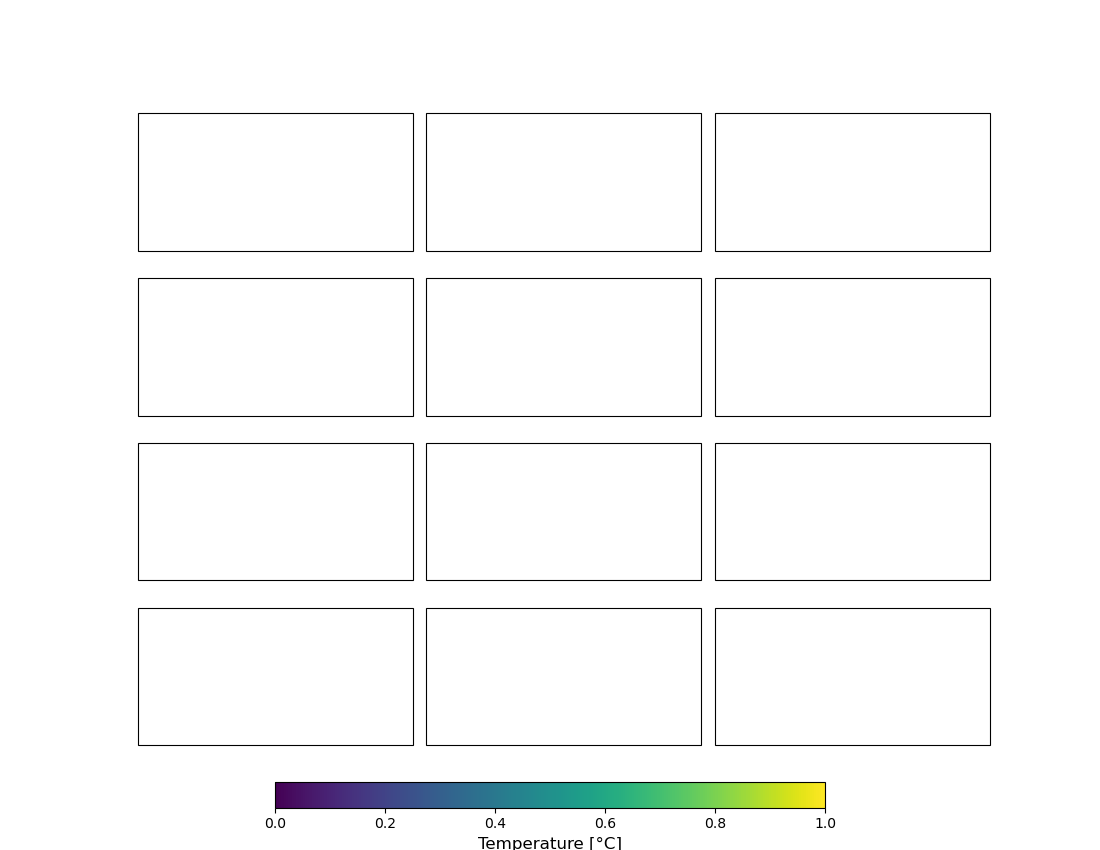

In [56]:
# Number of columns/rows for subplots
n_cols = 3
n_rows = 4

# Create one figure and a 4x7 grid of subplots
# The figsize is 10 across; adjust height as needed for clarity
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(11, 8.5),   
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Optional: if you want them *really* close, you can fine-tune spacing:
plt.subplots_adjust(wspace=0.05, hspace=0.03)
# plt.subplots_adjust(bottom=0.15)

# Counter for subplot index, and a handle to store the last "imshow" (for colorbar)
i = 0
im_obj = None

for lsatfile in lsatfiles:
    lsID = lsatfile
    print(lsID)
    
    mrow = valids[valids['L8_filename'].str.contains(lsatfile[:-15])]
    
    for idx, row in mrow.iterrows():
        # Check if L8_SST is NaN
        if pd.isnull(row['L8_SST']):
            # If it is NaN, skip this iteration and do not plot
            continue
        
        # --- Prepare data and coordinates ---
        ilat = row['A_lat']
        ilon = row['A_lon']
        
        lat_add = km_to_decimal_degrees(dist, ilat, direction='latitude')
        lon_add = km_to_decimal_degrees(dist, ilat, direction='longitude')
        xmin, ymin, xmax, ymax = (ilon - lon_add, ilat - lat_add, 
                                  ilon + lon_add, ilat + lat_add)
        
        # Load the Landsat file
        ds = xr.open_dataset(lsatfile, chunks=dict(x=512, y=512), engine='rasterio')
        ls_scene = ds['band_data'].sel(band=1).rio.write_crs("epsg:3031", inplace=True)
        
        # Assign time coordinate
        times = pd.to_datetime(lsatfile[17:25] + lsatfile[41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times, ID=lsatfile[:-8])
        
        # Reproject to EPSG:4326
        ls_scene = ls_scene.rio.reproject("EPSG:4326")

        # Calibrate using MODIS
        ls_scene = ls_scene * calib_m + calib_b

        # Remove all pixels that are too cold
        ls_scene = ls_scene.where(ls_scene>=lthresh,np.nan)
        
        # Select the subplot axis
        ax = axes[i // n_cols, i % n_cols]
        
        # Plot on that axis, without a colorbar
        # Store the "imshow" result in im_obj so we can build one colorbar later
        im_obj = ls_scene.plot.imshow(
            x='x', y='y',
            vmin=-2.0, vmax=1.5,
            ax=ax,
            transform=ccrs.PlateCarree(),
            origin='upper',
            add_colorbar=False  # <- No individual colorbar
        )
        
        # Remove titles completely (xarray may add one by default)
        ax.set_title('')
        
        # Set extent
        ax.set_extent([ilon - 0.4, ilon + 0.4, ilat - 0.2, ilat + 0.2], crs=ccrs.PlateCarree())
        
        # Argo observation
        ax.scatter([ilon], [ilat], c='r', s=3, transform=ccrs.PlateCarree(), label='Argo location')
        
        # Draw bounding box
        polygon_show = Pgon([(xmin, ymin), (xmin, ymax), 
                             (xmax, ymax), (xmax, ymin)],
                            closed=True, edgecolor='red', facecolor='none')
        ax.add_patch(polygon_show)
        
        # Text label
        text_str = (
            f"Argo ID: {row['Argo_id']}\n"
            f"Argo Temp: {np.around(row['Argo_SST'], 2)}\n"
            f"Landsat SST: {np.around(row['L8_SST'], 2)}"
        )
        ax.text(
            0.02, 0.95,
            text_str,
            transform=ax.transAxes,
            fontsize=10,
            va='top',
            ha='left'
        )

        gc.collect()
        
        # Move to next subplot index
        i += 1
        

# --- Add a single colorbar for the entire figure ---
# We use the last "imshow" (im_obj) and attach to all subplot axes
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])

cbar = fig.colorbar(
    im_obj, 
    ax=axes.ravel().tolist(),  # or just ax=axes if axes is 2D
    cax=cbar_ax,
    orientation='horizontal',  # 'vertical' or 'horizontal'
    fraction=0.025,            # how long the colorbar is relative to axes
    pad=0.05                   # space between colorbar and subplots
)
cbar.set_label("Temperature [°C]", fontsize=12)

# plt.tight_layout()
plt.show() 

# Use matchups to compare modeled and observed data
Here, we are going to use a linear regression

In [ ]:
# Remove low quality validation data from the valids data
rm_ids = [1460597, 1614080, 2143782, 2016236, 1790883]
rm = validmn[validmn.index.isin(rm_ids)]
validmn = validmn.drop(index=rm_ids, errors='ignore')
valids = valids[~valids['Argo_id'].isin(rm_ids)]

In [ ]:
# Orthoganal Regression 
data = validmn

# Original data
x_original = np.array(data['Argo_SST'])
y_original = np.array(data['L8_SST'])

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Compute RMSE
rmse = np.sqrt(((y_original - y_pred) ** 2).mean())

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))
print(f"RMSE: {np.around(rmse,2)}")

In [ ]:
beta_mdn = [beta[0]-beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_mup = [beta[0]+beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_bdn = [beta[0]-beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
beta_bup = [beta[0]+beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
print(f'At 95% confidence interval: {np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}, n={y_pred.shape[0]}')
xfill = np.array([-4.3,0.9])


# Plot data points and 1:1 line
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(labelsize=14)

xi = np.arange(-7.0,5.0,1.0)

# lower_err = abs(data['L8_SST'] - data['L8_SST_min'])  # distance to lower bound
# upper_err = abs(data['L8_SST_max'] - data['L8_SST'])  # distance to upper bound

ax.scatter(x_original,y_original,color='k',linewidth=0,s=35,label='High quality')
ax.errorbar(x_original,y_original,yerr=validmn['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# ax.errorbar(data['Argo_SST'],data['L8_SST'],yerr=[lower_err,upper_err],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# ax.scatter(data['Argo_SST'],data['center'],color='r',linewidth=0,s=25,label='_no label_')
ax.scatter(rm['Argo_SST'],rm['L8_SST'],color='0.7', s=35, label='Removed',zorder=2)
ax.plot(xi,xi,color='k',linewidth=2, label='1:1')
ax.plot(x_original, y_pred, color='k', ls=':', label='Validation ODR')
ax.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.1, facecolor='0.3')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
# a1.text(-2.1,-2.85,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}   p={p_val}',fontsize=12)
ax.text(-1.1,-1.5,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-1.95,1.5])
ax.set_xlim([-1.95,1.5])
ax.set_xlabel('Argo Temperature [°C]',fontsize=16)
ax.set_ylabel('Landsat SST [°C]',fontsize=16)
ax.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()